In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [4]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [5]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [6]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['x', 'measure', 'delay', 'h', 'id']>

In [7]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 71.11 # couldn't find
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [52]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    success1=0
    success0=0

#     if channel == '1':
#         if '0' in counts.keys():
#             success += counts['0']
#         else:
#             success +=0
# #         if '1' in counts.keys():
# #             success += counts['1']
#     elif channel == '2':
#         #if '0' in counts.keys():
#             #success += counts['0']
#         if '1' in counts.keys():
#             success += counts['1']
#         else:
#             success +=0
    if channel == '3':

        if '0' in counts.keys():
            success0 += counts['0']
        if '1' in counts.keys():
            success1 += counts['1']            
                    
    elif channel == '4':
        if '0' in counts.keys():
            success0 += counts['0']
        if '1' in counts.keys():
            success1 += counts['1']   
            
    return float(success0/shots),float(success1/shots)



In [54]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

(0.512, 0.488)

In [53]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

(0.511, 0.489)

# Plus State Graph

# Delay + measurement + gates

In [42]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '3'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [43]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.5122 0.51835 0.5165 0.5235500000000001 0.5229 0.5199 0.5276000000000001 0.5238 0.5379 0.5333 0.53995 0.539 0.5419 0.5453 0.5526 0.5412 0.5479 0.5537 0.55505 0.54905 0.56305 0.563 0.56015 0.56935 0.5727 0.5743499999999999 0.5826 0.5766 0.5812499999999999 0.5807 0.58465 0.58815 0.5896 0.5831999999999999 0.5943499999999999 0.595 0.5977 0.5985 0.5984499999999999 0.6001 0.5964499999999999 0.6083999999999999 0.6024499999999999 0.6164 0.6113 0.6076 0.6149 0.6213 0.6187 0.6133 0.62315 0.62565 0.62505 0.62655 0.6288 0.6393 0.63585 0.63965 0.63815 0.64475 0.6466500000000001 0.6434 0.6466000000000001 0.64535 0.6455 0.65575 0.6488 0.6547000000000001 0.6556500000000001 0.66 0.6595500000000001 0.667 0.6649 0.66005 0.6738500000000001 0.66925 0.67015 0.6739 0.67425 0.68075 0.6783 0.67725 0.6817 0.68335 0.67995 0.6802 0.6887 0.6891 0.6920499999999999 0.69445 0.68935 0.6897 0.68965 0.69455 0.6967 0.7033499999999999 0.6941499999999999 0.7087 0.7036 0.7035 0.71205 0.7123999999999999 0.7148 0.71455 0.721

In [44]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.4878 0.48165 0.4835 0.47645 0.47709999999999997 0.48009999999999997 0.4724 0.4762 0.4621 0.4667 0.46005 0.461 0.4581 0.4547 0.4474 0.4588 0.4521 0.44630000000000003 0.44495 0.45095 0.43695 0.437 0.43985 0.43065 0.4273 0.42565 0.4174 0.4234 0.41875 0.4193 0.41535 0.41185 0.4104 0.4168 0.40565 0.405 0.4023 0.4015 0.40155 0.3999 0.40355 0.3916 0.39755 0.3836 0.3887 0.3924 0.3851 0.3787 0.38130000000000003 0.3867 0.37685 0.37435 0.37495 0.37345 0.3712 0.3607 0.36415 0.36035 0.36185 0.35525 0.35335 0.3566 0.3534 0.35465 0.3545 0.34425 0.3512 0.3453 0.34435 0.34 0.34045000000000003 0.333 0.3351 0.33995 0.32615 0.33075 0.32985 0.3261 0.32575 0.31925000000000003 0.3217 0.32275 0.3183 0.31665 0.32005 0.31980000000000003 0.3113 0.3109 0.30795 0.30555 0.31065 0.3103 0.31035 0.30545 0.3033 0.29664999999999997 0.30585 0.2913 0.2964 0.2965 0.28795 0.28759999999999997 0.2852 0.28545 0.27855 0.2842 0.2811 0.2823 0.27715 0.28105 0.27435 0.2778 0.2751 0.27185 0.26795 0.2754 0.2675 0.271 0.26325 0.2628

In [46]:
y1=[0.4878,0.48165,0.4835,0.47645,0.47709999999999997,0.48009999999999997,0.4724,0.4762,0.4621,0.4667,0.46005,0.461,0.4581,0.4547,0.4474,0.4588,0.4521,0.44630000000000003,0.44495,0.45095,0.43695,0.437,0.43985,0.43065,0.4273,0.42565,0.4174,0.4234,0.41875,0.4193,0.41535,0.41185,0.4104,0.4168,0.40565,0.405,0.4023,0.4015,0.40155,0.3999,0.40355,0.3916,0.39755,0.3836,0.3887,0.3924,0.3851,0.3787,0.38130000000000003,0.3867,0.37685,0.37435,0.37495,0.37345,0.3712,0.3607,0.36415,0.36035,0.36185,0.35525,0.35335,0.3566,0.3534,0.35465,0.3545,0.34425,0.3512,0.3453,0.34435,0.34,0.34045000000000003,0.333,0.3351,0.33995,0.32615,0.33075,0.32985,0.3261,0.32575,0.31925000000000003,0.3217,0.32275,0.3183,0.31665,0.32005,0.31980000000000003,0.3113,0.3109,0.30795,0.30555,0.31065,0.3103,0.31035,0.30545,0.3033,0.29664999999999997,0.30585,0.2913,0.2964,0.2965,0.28795,0.28759999999999997,0.2852,0.28545,0.27855,0.2842,0.2811,0.2823,0.27715,0.28105,0.27435,0.2778,0.2751,0.27185,0.26795,0.2754,0.2675,0.271,0.26325,0.26280000000000003,0.2642,0.26080000000000003,0.265,0.254,0.25765,0.2542,0.2538,0.25695,0.24815,0.25345,0.2549,0.2465,0.24805,0.24865,0.24130000000000001,0.24395,0.24125,0.24265,0.2347,0.2427,0.23825,0.2316,0.2333,0.2325,0.2281,0.2301,0.22625,0.22485,0.22105,0.22735,0.225,0.2239,0.2202,0.22075,0.22195,0.21945,0.21655,0.2191,0.21265,0.21065,0.21185,0.20705,0.2128,0.20845,0.21115,0.207,0.2028,0.20855,0.20024999999999998,0.20655,0.2028,0.1933,0.1979,0.19965,0.1979,0.1975,0.19269999999999998,0.19845000000000002,0.197,0.19525,0.19155,0.191,0.187,0.1848,0.1864,0.19025,0.188,0.1838,0.1859,0.1794,0.17985,0.18095,0.1776,0.18005,0.18045,0.17615,0.1792,0.17775,0.1727,0.16755,0.16975,0.17075,0.17095,0.17005,0.1728,0.1708,0.1694,0.16615,0.1635,0.16305,0.16225,0.1656,0.15985,0.15940000000000001,0.16555,0.1608,0.16085,0.15885,0.1543,0.1583,0.15385,0.1532,0.15745,0.1552,0.1525,0.1517,0.14945,0.1478,0.1517,0.1513,0.14705,0.1495,0.1477,0.1476,0.14225,0.14225000000000002,0.14215,0.1383,0.14285,0.14045,0.13795,0.1414,0.13755,0.1396,0.13765,0.13725,0.14045,0.13285,0.13605,0.13195,0.1323,0.1329,0.13295,0.13265,0.1287,0.1251,0.12895,0.12835,0.1297,0.1303,0.1269,0.12805,0.12345,0.12435,0.12095,0.12380000000000001,0.1232,0.12040000000000001,0.1224,0.12265,0.12095,0.12005,0.1164,0.1148,0.11695,0.11825000000000001,0.117,0.11845,0.11605,0.11635,0.1131,0.11445,0.1104,0.11355,0.1113,0.11075,0.1096,0.10725,0.1131,0.10825,0.10795,0.104,0.1108,0.10995,0.10595,0.10625,0.1037,0.10565,0.1059,0.10415,0.1034,0.09975,0.10095,0.1018,0.10015,0.1003,0.0989,0.0988,0.099,0.0998,0.098,0.09555,0.09375,0.09485,0.0949,0.092,0.09595,0.0923,0.093,0.09435,0.0915,0.0948,0.0942,0.0876,0.09325,0.0865,0.09004999999999999,0.08985,0.09175,0.0874,0.0884,0.092,0.0878,0.08665,0.08645,0.08475,0.08585,0.08335000000000001,0.0838,0.08195,0.08395,0.0837,0.08115,0.08195,0.081,0.08315,0.0823,0.08105,0.07725,0.07985,0.07875,0.08015,0.07885,0.0812,0.0779,0.07845,0.0748,0.0778,0.0784,0.0783,0.07485,0.07350000000000001,0.0739,0.07575,0.07335,0.0746,0.0726,0.07065,0.07275,0.07214999999999999,0.0726,0.0732,0.06945,0.07065,0.0691,0.06795,0.07005,0.07045,0.06915,0.06805,0.06615,0.0663,0.06755,0.0649,0.06645,0.0633,0.06285,0.06545,0.06605,0.0626,0.06485,0.0648,0.06385,0.0671,0.0641,0.0607,0.0611,0.0602,0.0632,0.06155,0.0625,0.05955,0.06105,0.06035,0.0594,0.0604,0.05885,0.0606,0.0589,0.059,0.0599,0.06105,0.0586,0.0571,0.0584,0.0569,0.0573,0.0555,0.0569,0.0557,0.0556,0.05585,0.0563,0.05455,0.05675,0.05445,0.0508,0.05275,0.05435,0.0512,0.05205,0.05525,0.0534,0.05235,0.0526,0.05355,0.049,0.05075,0.05125,0.0473,0.05045,0.0463,0.049,0.04895,0.0488,0.04755,0.04665,0.04735,0.047,0.04705,0.04685,0.04615,0.0477,0.04855,0.04705,0.04615,0.0453,0.04485,0.04605,0.045899999999999996,0.0451,0.04495,0.044899999999999995,0.0441,0.0431,0.043,0.0427,0.042050000000000004,0.04215,0.0439,0.0449,0.039,0.04395,0.03905,0.0407,0.04195,0.0423,0.0423,0.04105,0.03985,0.03975,0.0385,0.0407,0.0391,0.03915,0.03805,0.0378,0.0398,0.03855,0.0394,0.041550000000000004,0.0392,0.038,0.03955,0.03895,0.0368,0.03665,0.0393,0.0344,0.03635,0.03535,0.03615,0.03955,0.03515,0.0355,0.0348,0.0355,0.03505,0.0352,0.03425,0.03475,0.0341,0.0329,0.03595,0.0336,0.03315,0.03335,0.0324,0.03315,0.03285,0.03325,0.0339,0.0318,0.0333,0.032,0.03365,0.0315,0.0313,0.03215,0.02955,0.0308,0.03115,0.0298,0.03105,0.0297,0.03,0.028650000000000002,0.0285,0.030100000000000002,0.0285,0.03045,0.02945,0.0282,0.02885,0.02715,0.02975,0.0291,0.02825,0.03005,0.0281,0.02635,0.0297,0.0313,0.0291,0.0266,0.02645,0.02675,0.02645,0.0258,0.02755,0.0263,0.02645,0.0277,0.02535,0.0256,0.028,0.027,0.025500000000000002,0.02555,0.0261,0.02435,0.0247,0.02565,0.0235,0.026099999999999998,0.0245,0.0234,0.0259,0.0248,0.024050000000000002,0.0244,0.02405,0.02185,0.0251,0.02285,0.0207,0.0232,0.02455,0.0221,0.0228,0.0224,0.0241,0.0217,0.021500000000000002,0.02145,0.0235,0.02305,0.0223,0.0202,0.0212,0.0213,0.024050000000000002,0.023,0.02045,0.0224,0.02065,0.01995,0.0215,0.0201,0.0209,0.02025,0.0213,0.01855,0.01985,0.02145,0.01955,0.0205,0.019,0.01935,0.01905,0.01765,0.02045,0.01885,0.01975,0.017750000000000002,0.01985,0.0185,0.0203,0.0172,0.01965,0.0203,0.02045,0.0179,0.019450000000000002,0.0174,0.01895,0.0186,0.0173,0.0153,0.0178,0.0166,0.017,0.01845,0.01635,0.0186,0.01565,0.018,0.015050000000000001,0.0165,0.01855,0.01565,0.01745,0.01695,0.01725,0.015,0.0156,0.0156,0.0159,0.0153,0.0172,0.0153,0.01445,0.01575,0.01345,0.0148,0.01585,0.015349999999999999,0.0153,0.0154,0.01565,0.01565,0.0147,0.01495,0.01635,0.01475,0.01555,0.0159,0.01565,0.01295,0.01565,0.01405,0.0135,0.01385,0.0141,0.0146,0.0138,0.015,0.0136,0.01375,0.01435,0.0132,0.013049999999999999,0.01465,0.0132,0.0126,0.0146,0.01235,0.0142,0.01415,0.0134,0.012,0.0133,0.01245,0.013,0.01205,0.013649999999999999,0.0137,0.01265,0.0124,0.01325,0.0123,0.0124,0.01125,0.01125,0.01245,0.0124,0.0117,0.011349999999999999,0.01115,0.01135,0.01255,0.0111,0.01135,0.01125,0.0116,0.011649999999999999,0.01065,0.0109,0.01065,0.00935,0.00995,0.0111,0.01045,0.01035,0.0103,0.01205,0.01095,0.00975,0.0108,0.0095,0.0103,0.01035,0.0104,0.01065,0.00975,0.00905,0.01025,0.01045,0.0106,0.01115,0.0094,0.01045,0.00995,0.0088,0.00965,0.0106,0.00985,0.01025,0.0104,0.0096,0.0104,0.00915,0.0083,0.01005,0.0091,0.01015,0.008,0.01135,0.009049999999999999,0.0082,0.00965,0.00945,0.0091,0.00945,0.00845,0.009899999999999999,0.00845,0.00985,0.008,0.0093,0.00935,0.00835,0.00945,0.0089,0.0082,0.0083,0.0076,0.0083,0.0085,0.0093,0.00905,0.0085,0.00835,0.0093,0.0076,0.00775,0.00715,0.00665,0.00675,0.00805,0.00885,0.0069,0.00755,0.0061,0.00865,0.0078,0.0088,0.00735,0.0067,0.00705,0.0072,0.0074,0.00665,0.00755,0.00585,0.0067,0.0071,0.0072,0.0073,0.0071,0.0072,0.00635,0.00725,0.00535,0.00605,0.00705,0.00595,0.0071,0.0063,0.00695,0.0064,0.0064,0.0067,0.0066,0.00655,0.0063,0.0056500000000000005,0.0066,0.006,0.0063,0.00575,0.0068,0.00645,0.00665,0.00575,0.00575,0.007,0.0053,0.0054,0.00605,0.00575,0.00705,0.0058,0.00605,0.0057,0.0058,0.0059499999999999996,0.0046,0.0058,0.0055,0.0056500000000000005,0.00555,0.0062,0.00525,0.00535,0.00575,0.0051,0.00505,0.00535,0.0052,0.0054,0.0053,0.00655,0.0056500000000000005,0.0056500000000000005,0.0053,0.00445,0.0059,0.0055,0.0051,0.00545,0.0048000000000000004,0.005,0.0047,0.00485,0.00435,0.0046500000000000005,0.00485,0.00425,0.0053,0.00425,0.0049,0.00445,0.0055,0.0049,0.0047,0.00465,0.00495,0.0051,0.005,0.0046,0.00345,0.005,0.00435,0.00465,0.00415,0.00495,0.0039000000000000003,0.0046500000000000005,0.00385,0.0044,0.00525,0.004,0.00455,0.0046,0.00485,0.0037,0.0042,0.0045,0.00385,0.00375,0.00365,0.0036,0.00415,0.00405,0.00465,0.0041,0.00285,0.0041,0.00315,0.00495,0.00415,0.0036,0.0037,0.004,0.0037,0.0037,0.0032500000000000003,0.00335,0.0041,0.0038,0.0036,0.00445,0.00375,0.00375,0.0035,0.00385,0.0041,0.0039000000000000003,0.00345,0.0036,0.003,0.00305,0.00395,0.00355,0.003,0.0028,0.00355,0.0038,0.0034000000000000002,0.00335,0.0033,0.0032500000000000003,0.0033,0.0038,0.0027,0.0027,0.00355,0.004,0.0028,0.00315,0.0033,0.0027,0.00295,0.0032,0.004,0.0032,0.00315,0.0035,0.00365,0.0034000000000000002,0.00315,0.00295,0.0026,0.003,0.0034000000000000002,0.0025,0.0032500000000000003,0.00285,0.0028,0.00285,0.002,0.0028,0.00265,0.0029000000000000002,0.00305,0.0032500000000000003,0.0029000000000000002,0.00335,0.00305,0.0027]

In [45]:
y2=[0.5122,0.51835,0.5165,0.5235500000000001,0.5229,0.5199,0.5276000000000001,0.5238,0.5379,0.5333,0.53995,0.539,0.5419,0.5453,0.5526,0.5412,0.5479,0.5537,0.55505,0.54905,0.56305,0.563,0.56015,0.56935,0.5727,0.5743499999999999,0.5826,0.5766,0.5812499999999999,0.5807,0.58465,0.58815,0.5896,0.5831999999999999,0.5943499999999999,0.595,0.5977,0.5985,0.5984499999999999,0.6001,0.5964499999999999,0.6083999999999999,0.6024499999999999,0.6164,0.6113,0.6076,0.6149,0.6213,0.6187,0.6133,0.62315,0.62565,0.62505,0.62655,0.6288,0.6393,0.63585,0.63965,0.63815,0.64475,0.6466500000000001,0.6434,0.6466000000000001,0.64535,0.6455,0.65575,0.6488,0.6547000000000001,0.6556500000000001,0.66,0.6595500000000001,0.667,0.6649,0.66005,0.6738500000000001,0.66925,0.67015,0.6739,0.67425,0.68075,0.6783,0.67725,0.6817,0.68335,0.67995,0.6802,0.6887,0.6891,0.6920499999999999,0.69445,0.68935,0.6897,0.68965,0.69455,0.6967,0.7033499999999999,0.6941499999999999,0.7087,0.7036,0.7035,0.71205,0.7123999999999999,0.7148,0.71455,0.7214499999999999,0.7158,0.7189,0.7177,0.72285,0.71895,0.72565,0.7222,0.7249,0.72815,0.73205,0.7246,0.7324999999999999,0.729,0.73675,0.7372,0.7358,0.7392,0.735,0.746,0.74235,0.7458,0.7462,0.74305,0.75185,0.74655,0.7451,0.7535000000000001,0.75195,0.75135,0.7587,0.75605,0.75875,0.75735,0.7653,0.7573,0.76175,0.7684,0.7667,0.7675000000000001,0.7719,0.7699,0.77375,0.77515,0.77895,0.7726500000000001,0.775,0.7761,0.7798,0.77925,0.77805,0.7805500000000001,0.78345,0.7809,0.78735,0.78935,0.78815,0.79295,0.7872,0.7915500000000001,0.78885,0.793,0.7972,0.79145,0.79975,0.79345,0.7972,0.8067,0.8021,0.80035,0.8021,0.8025,0.8073,0.80155,0.803,0.8047500000000001,0.80845,0.809,0.813,0.8152,0.8136,0.80975,0.8119999999999999,0.8162,0.8141,0.8206,0.8201499999999999,0.81905,0.8224,0.81995,0.81955,0.82385,0.8208,0.8222499999999999,0.8272999999999999,0.8324499999999999,0.8302499999999999,0.8292499999999999,0.82905,0.82995,0.8271999999999999,0.8291999999999999,0.8306,0.83385,0.8365,0.83695,0.83775,0.8343999999999999,0.84015,0.8406,0.8344499999999999,0.8392,0.83915,0.84115,0.8457,0.8417,0.84615,0.8468,0.84255,0.8448,0.8474999999999999,0.8482999999999999,0.85055,0.8522,0.8482999999999999,0.8487,0.85295,0.8505,0.8523,0.8523999999999999,0.85775,0.85775,0.85785,0.8617,0.85715,0.85955,0.86205,0.8586,0.8624499999999999,0.8603999999999999,0.86235,0.86275,0.85955,0.86715,0.86395,0.86805,0.8677,0.8671,0.86705,0.86735,0.8713,0.8749,0.87105,0.87165,0.8703,0.8697,0.8731,0.87195,0.87655,0.87565,0.87905,0.8762,0.8768,0.8796,0.8776,0.87735,0.87905,0.87995,0.8836,0.8852,0.88305,0.88175,0.883,0.8815500000000001,0.88395,0.88365,0.8869,0.8855500000000001,0.8896000000000001,0.88645,0.8887,0.88925,0.8904,0.89275,0.8869,0.89175,0.89205,0.896,0.8892,0.89005,0.89405,0.89375,0.8963,0.89435,0.8941,0.89585,0.8966000000000001,0.90025,0.89905,0.8982,0.89985,0.8997,0.9011,0.9012,0.901,0.9002,0.902,0.90445,0.90625,0.90515,0.9051,0.908,0.90405,0.9077000000000001,0.907,0.9056500000000001,0.9085000000000001,0.9052,0.9058,0.9124,0.9067500000000001,0.9135,0.90995,0.91015,0.90825,0.9126000000000001,0.9116000000000001,0.908,0.9122,0.91335,0.9135500000000001,0.91525,0.91415,0.9166500000000001,0.9162,0.91805,0.91605,0.9163,0.9188500000000001,0.91805,0.919,0.91685,0.9177000000000001,0.91895,0.9227500000000001,0.92015,0.92125,0.9198500000000001,0.92115,0.9188000000000001,0.9221,0.9215500000000001,0.9252,0.9222,0.9216000000000001,0.9217000000000001,0.92515,0.9265,0.9261,0.92425,0.9266500000000001,0.9254,0.9274,0.92935,0.92725,0.9278500000000001,0.9274,0.9268000000000001,0.93055,0.92935,0.9309000000000001,0.93205,0.92995,0.92955,0.9308500000000001,0.9319500000000001,0.93385,0.9337,0.93245,0.9351,0.93355,0.9367,0.93715,0.93455,0.9339500000000001,0.9374,0.93515,0.9352,0.93615,0.9329000000000001,0.9359,0.9393,0.9389,0.9398,0.9368,0.93845,0.9375,0.94045,0.93895,0.93965,0.9406,0.9396,0.9411499999999999,0.9394,0.9410999999999999,0.941,0.9400999999999999,0.93895,0.9414,0.9429,0.9416,0.9430999999999999,0.9427,0.9445,0.9430999999999999,0.9442999999999999,0.9444,0.9441499999999999,0.9437,0.94545,0.9432499999999999,0.94555,0.9491999999999999,0.9472499999999999,0.94565,0.9488,0.94795,0.94475,0.9466,0.94765,0.9473999999999999,0.94645,0.951,0.9492499999999999,0.94875,0.9527,0.94955,0.9537,0.951,0.95105,0.9511999999999999,0.9524499999999999,0.9533499999999999,0.95265,0.953,0.95295,0.9531499999999999,0.95385,0.9522999999999999,0.9514499999999999,0.95295,0.95385,0.9547,0.9551499999999999,0.95395,0.9541,0.9549,0.95505,0.9551,0.9559,0.9569,0.957,0.9572999999999999,0.95795,0.95785,0.9561,0.9551,0.961,0.95605,0.96095,0.9592999999999999,0.95805,0.9577,0.9577,0.95895,0.96015,0.9602499999999999,0.9615,0.9592999999999999,0.9609,0.96085,0.96195,0.9621999999999999,0.9601999999999999,0.9614499999999999,0.9606,0.9584499999999999,0.9608,0.962,0.9604499999999999,0.96105,0.9632,0.9633499999999999,0.9607,0.9656,0.96365,0.96465,0.96385,0.9604499999999999,0.96485,0.9644999999999999,0.9652,0.9644999999999999,0.96495,0.9648,0.96575,0.9652499999999999,0.9659,0.9671,0.96405,0.9663999999999999,0.96685,0.96665,0.9676,0.96685,0.96715,0.96675,0.9661,0.9682,0.9667,0.968,0.9663499999999999,0.9684999999999999,0.9687,0.96785,0.9704499999999999,0.9692,0.96885,0.9702,0.96895,0.9702999999999999,0.97,0.9713499999999999,0.9715,0.9699,0.9715,0.96955,0.97055,0.9718,0.97115,0.97285,0.97025,0.9709,0.97175,0.96995,0.9719,0.97365,0.9702999999999999,0.9687,0.9709,0.9733999999999999,0.97355,0.97325,0.97355,0.9742,0.9724499999999999,0.9737,0.97355,0.9722999999999999,0.97465,0.9743999999999999,0.972,0.973,0.9744999999999999,0.9744499999999999,0.9739,0.97565,0.9753,0.9743499999999999,0.9764999999999999,0.9739,0.9755,0.9766,0.9741,0.9752,0.97595,0.9756,0.97595,0.97815,0.9749,0.97715,0.9793,0.9768,0.9754499999999999,0.9779,0.9772,0.9776,0.9759,0.9783,0.9784999999999999,0.97855,0.9764999999999999,0.97695,0.9777,0.9798,0.9788,0.9787,0.97595,0.977,0.97955,0.9776,0.9793499999999999,0.98005,0.9784999999999999,0.9799,0.9791,0.97975,0.9787,0.9814499999999999,0.98015,0.97855,0.9804499999999999,0.9795,0.981,0.98065,0.98095,0.98235,0.97955,0.98115,0.98025,0.98225,0.98015,0.9815,0.9797,0.9828,0.9803499999999999,0.9797,0.97955,0.9821,0.98055,0.9826,0.98105,0.9813999999999999,0.9827,0.9847,0.9822,0.9833999999999999,0.983,0.98155,0.98365,0.9813999999999999,0.98435,0.982,0.98495,0.9835,0.9814499999999999,0.98435,0.98255,0.98305,0.98275,0.985,0.9843999999999999,0.9843999999999999,0.9841,0.9847,0.9828,0.9847,0.98555,0.98425,0.98655,0.9852,0.98415,0.98465,0.9847,0.9846,0.98435,0.98435,0.9853,0.98505,0.98365,0.98525,0.9844499999999999,0.9841,0.98435,0.98705,0.98435,0.98595,0.9864999999999999,0.98615,0.9859,0.9853999999999999,0.9862,0.985,0.9863999999999999,0.98625,0.98565,0.9868,0.98695,0.98535,0.9868,0.9873999999999999,0.9853999999999999,0.98765,0.9858,0.98585,0.9866,0.988,0.9867,0.98755,0.987,0.98795,0.98635,0.9863,0.98735,0.9876,0.98675,0.9877,0.9876,0.98875,0.98875,0.98755,0.9876,0.9883,0.98865,0.98885,0.98865,0.9874499999999999,0.9889,0.98865,0.98875,0.9884,0.98835,0.98935,0.9891,0.98935,0.99065,0.99005,0.9889,0.98955,0.98965,0.9897,0.98795,0.98905,0.99025,0.9892,0.9904999999999999,0.9897,0.98965,0.9896,0.98935,0.99025,0.99095,0.98975,0.98955,0.9894,0.98885,0.9906,0.98955,0.99005,0.9912,0.99035,0.9894,0.99015,0.98975,0.9896,0.9904,0.9896,0.99085,0.9917,0.98995,0.9909,0.98985,0.992,0.98865,0.99095,0.9918,0.99035,0.99055,0.9909,0.99055,0.99155,0.9901,0.99155,0.99015,0.992,0.9907,0.99065,0.99165,0.99055,0.9911,0.9918,0.9917,0.9924,0.9917,0.9915,0.9907,0.99095,0.9915,0.99165,0.9907,0.9924,0.99225,0.99285,0.99335,0.99325,0.99195,0.99115,0.9931,0.9924499999999999,0.9939,0.99135,0.9922,0.9912,0.99265,0.9933,0.99295,0.9928,0.9926,0.99335,0.9924499999999999,0.99415,0.9933,0.9929,0.9928,0.9927,0.9929,0.9928,0.99365,0.99275,0.99465,0.99395,0.99295,0.99405,0.9929,0.9937,0.99305,0.9936,0.9936,0.9933,0.9934,0.9934499999999999,0.9937,0.99435,0.9934,0.994,0.9937,0.99425,0.9932,0.99355,0.99335,0.99425,0.99425,0.993,0.9947,0.9946,0.99395,0.99425,0.99295,0.9942,0.99395,0.9943,0.9942,0.99405,0.9954,0.9942,0.9944999999999999,0.99435,0.99445,0.9938,0.99475,0.99465,0.99425,0.9949,0.99495,0.99465,0.9948,0.9946,0.9947,0.9934499999999999,0.99435,0.99435,0.9947,0.99555,0.9941,0.9944999999999999,0.9949,0.99455,0.9952,0.995,0.9953,0.99515,0.99565,0.99535,0.99515,0.99575,0.9947,0.99575,0.9951,0.99555,0.9944999999999999,0.9951,0.9953,0.99535,0.99505,0.9949,0.995,0.9954,0.99655,0.995,0.99565,0.99535,0.99585,0.99505,0.9961,0.99535,0.99615,0.9956,0.99475,0.996,0.99545,0.9954,0.99515,0.9963,0.9958,0.9955,0.99615,0.99625,0.99635,0.9964,0.99585,0.99595,0.99535,0.9959,0.99715,0.9959,0.99685,0.99505,0.99585,0.9964,0.9963,0.996,0.9963,0.9963,0.99675,0.99665,0.9959,0.9962,0.9964,0.99555,0.99625,0.99625,0.9964999999999999,0.99615,0.9959,0.9961,0.99655,0.9964,0.997,0.99695,0.99605,0.99645,0.997,0.9972,0.99645,0.9962,0.9966,0.99665,0.9967,0.99675,0.9967,0.9962,0.9973,0.9973,0.99645,0.996,0.9972,0.99685,0.9967,0.9973,0.99705,0.9968,0.996,0.9968,0.99685,0.9964999999999999,0.99635,0.9966,0.99685,0.99705,0.9974,0.997,0.9966,0.9975,0.99675,0.99715,0.9972,0.99715,0.998,0.9972,0.99735,0.9971,0.99695,0.99675,0.9971,0.99665,0.99695,0.99725]

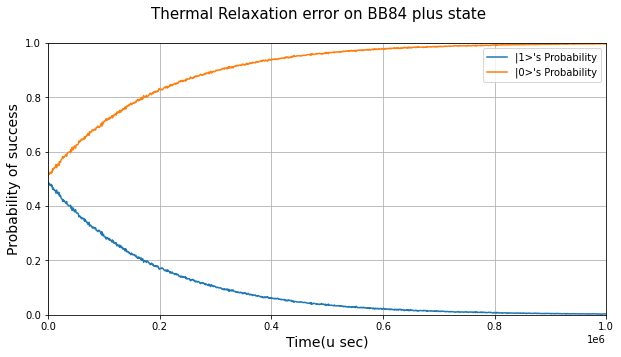

<Figure size 576x360 with 0 Axes>

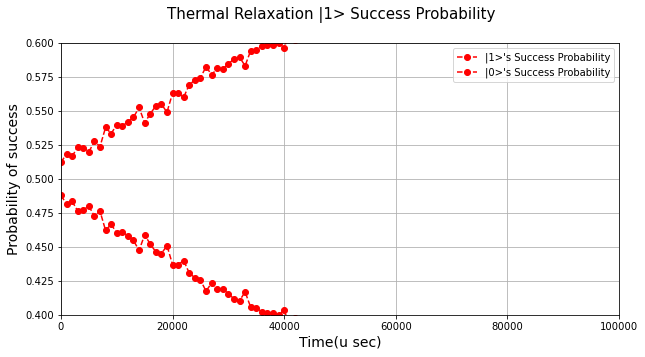

<Figure size 576x360 with 0 Axes>

In [58]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 plus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, y1, label = "|1>'s Probability")
ax.plot(x2, y2, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,y1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,y2,'ro--',label = "|0>'s Success Probability")

ax.legend()

# Minus State Graph

# Delay + measurement + gates

In [55]:
import matplotlib.pyplot as plt
success_state0=[]
success_state1=[]

for j in range(20):
    delay = np.arange(0,1001000,1000)
    channel = '4'
    apply_error = {"delay":True, "measure": True, "gate": True}
    success0 = []
    success1 = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success0.append(prob[0])
        success1.append(prob[1])
    success_state0.append(success0)
    success_state1.append(success1)

In [56]:
from statistics import mean
a= success_state0
print(*map(mean, zip(*a)))

0.5178 0.51605 0.5173 0.5213 0.53005 0.5215000000000001 0.523 0.53005 0.5325 0.53615 0.5399 0.5385 0.5422 0.5427000000000001 0.5435 0.552 0.5445500000000001 0.55505 0.55455 0.56345 0.55805 0.56045 0.5648 0.56735 0.5694 0.5789 0.57675 0.57 0.57955 0.57775 0.57845 0.58815 0.5887 0.58355 0.5952999999999999 0.5943999999999999 0.60155 0.5924499999999999 0.60835 0.601 0.604 0.60805 0.61525 0.60915 0.61055 0.6164 0.61565 0.6234999999999999 0.6201 0.6214 0.62065 0.6227 0.62715 0.6381 0.6238 0.6348 0.6353 0.6372 0.63905 0.6374 0.6449 0.6465000000000001 0.64375 0.647 0.6493 0.64785 0.65275 0.6545500000000001 0.65445 0.6602 0.6567500000000001 0.6549 0.66425 0.6707000000000001 0.6655 0.669 0.6714 0.67365 0.6752 0.68285 0.6803 0.6802 0.68475 0.68175 0.6986 0.6862 0.6882 0.68715 0.6911 0.69645 0.69285 0.6962 0.6980999999999999 0.6999 0.70205 0.70305 0.7028 0.7027 0.7054 0.7165 0.71185 0.7119 0.71665 0.7176 0.71375 0.7145 0.71565 0.72055 0.72225 0.7213999999999999 0.7253499999999999 0.7278 0.73055 0.

In [57]:
from statistics import mean
a= success_state1
print(*map(mean, zip(*a)))

0.4822 0.48395 0.4827 0.4787 0.46995 0.4785 0.477 0.46995 0.4675 0.46385 0.4601 0.4615 0.4578 0.4573 0.4565 0.448 0.45545 0.44495 0.44545 0.43655 0.44195 0.43955 0.4352 0.43265 0.4306 0.4211 0.42325 0.43 0.42045 0.42225 0.42155 0.41185 0.4113 0.41645 0.4047 0.4056 0.39845 0.40755 0.39165 0.399 0.396 0.39195 0.38475 0.39085000000000003 0.38945 0.3836 0.38435 0.3765 0.3799 0.3786 0.37935 0.3773 0.37285 0.3619 0.3762 0.36519999999999997 0.3647 0.3628 0.36095 0.3626 0.35509999999999997 0.3535 0.35625 0.353 0.3507 0.35215 0.34725 0.34545 0.34555 0.3398 0.34325 0.3451 0.33575 0.3293 0.3345 0.331 0.3286 0.32635000000000003 0.32480000000000003 0.31715 0.3197 0.31980000000000003 0.31525000000000003 0.31825 0.3014 0.3138 0.3118 0.31285 0.3089 0.30355 0.30715 0.3038 0.3019 0.3001 0.29795 0.29695 0.2972 0.2973 0.2946 0.2835 0.28815 0.2881 0.28335 0.2824 0.28625 0.2855 0.28435 0.27945 0.27775 0.2786 0.27465 0.2722 0.26945 0.2679 0.26645 0.2691 0.2677 0.27040000000000003 0.2647 0.26525 0.26940000000

In [61]:
yy1=[0.4822,0.48395,0.4827,0.4787,0.46995,0.4785,0.477,0.46995,0.4675,0.46385,0.4601,0.4615,0.4578,0.4573,0.4565,0.448,0.45545,0.44495,0.44545,0.43655,0.44195,0.43955,0.4352,0.43265,0.4306,0.4211,0.42325,0.43,0.42045,0.42225,0.42155,0.41185,0.4113,0.41645,0.4047,0.4056,0.39845,0.40755,0.39165,0.399,0.396,0.39195,0.38475,0.39085000000000003,0.38945,0.3836,0.38435,0.3765,0.3799,0.3786,0.37935,0.3773,0.37285,0.3619,0.3762,0.36519999999999997,0.3647,0.3628,0.36095,0.3626,0.35509999999999997,0.3535,0.35625,0.353,0.3507,0.35215,0.34725,0.34545,0.34555,0.3398,0.34325,0.3451,0.33575,0.3293,0.3345,0.331,0.3286,0.32635000000000003,0.32480000000000003,0.31715,0.3197,0.31980000000000003,0.31525000000000003,0.31825,0.3014,0.3138,0.3118,0.31285,0.3089,0.30355,0.30715,0.3038,0.3019,0.3001,0.29795,0.29695,0.2972,0.2973,0.2946,0.2835,0.28815,0.2881,0.28335,0.2824,0.28625,0.2855,0.28435,0.27945,0.27775,0.2786,0.27465,0.2722,0.26945,0.2679,0.26645,0.2691,0.2677,0.27040000000000003,0.2647,0.26525,0.26940000000000003,0.26695,0.26415,0.2537,0.25680000000000003,0.26115,0.25335,0.2503,0.2502,0.25345,0.25645,0.2385,0.24745,0.2457,0.24855,0.24165,0.24405,0.2396,0.24355,0.24045,0.2339,0.234,0.2386,0.23215,0.2315,0.2307,0.22915,0.22885,0.22125,0.22775,0.22625,0.22415,0.2219,0.2216,0.22045,0.22205,0.21795,0.2122,0.21235,0.2158,0.2112,0.20765,0.21075,0.20829999999999999,0.2111,0.21015,0.20675,0.20515,0.2057,0.2007,0.2022,0.2034,0.1993,0.19935,0.2034,0.20025,0.1939,0.1918,0.19745000000000001,0.19205,0.19205,0.19090000000000001,0.19335,0.18765,0.1905,0.1878,0.18295,0.18645,0.18625,0.18555,0.1802,0.181,0.1825,0.17475,0.1802,0.17795,0.1779,0.18125,0.1728,0.1771,0.1739,0.17355,0.17315,0.17115,0.1711,0.17075,0.1674,0.17024999999999998,0.1706,0.1649,0.1686,0.16295,0.165,0.1602,0.16635,0.15395,0.1555,0.14965,0.15715,0.1575,0.1561,0.15545,0.15505,0.151,0.1521,0.15045,0.1521,0.15545,0.1484,0.14865,0.1474,0.14175000000000001,0.1441,0.14505,0.14425,0.1452,0.1433,0.14345,0.1459,0.13915,0.142,0.13845,0.13785,0.14045,0.14195,0.135,0.1393,0.13275,0.13435,0.1341,0.13225,0.1325,0.12865000000000001,0.13365,0.12975,0.13045,0.1299,0.1298,0.12825,0.12875,0.126,0.12665,0.12245,0.12535,0.12085,0.12355000000000001,0.12285,0.11955,0.12255,0.11995,0.11785,0.11985,0.11995,0.11675,0.11655,0.11775000000000001,0.11845,0.11915,0.1132,0.1171,0.11475,0.1154,0.11435000000000001,0.11215,0.1148,0.1121,0.1097,0.1095,0.111,0.11045,0.10545,0.1097,0.1072,0.10585,0.10535,0.1075,0.1074,0.1029,0.10295,0.10475,0.10105,0.1027,0.10345,0.1043,0.1031,0.1012,0.09935,0.09935,0.09855,0.0975,0.09845,0.0955,0.10065,0.09755,0.0933,0.097,0.09865,0.0946,0.0947,0.09215,0.09675,0.0921,0.09195,0.0915,0.09145,0.0903,0.09305,0.0909,0.0883,0.0928,0.09145,0.08955,0.0852,0.08925,0.09005,0.0832,0.0837,0.08475,0.08485,0.08295,0.08645,0.08515,0.08155,0.08475,0.08205,0.08209999999999999,0.0807,0.07995000000000001,0.08085,0.08215,0.08105,0.0813,0.07855,0.0798,0.08235,0.08155,0.0801,0.07725,0.0767,0.07475,0.0737,0.0726,0.07305,0.0746,0.07565,0.07495,0.06965,0.0719,0.0712,0.0708,0.07135,0.0707,0.07175000000000001,0.0731,0.0701,0.0684,0.06995,0.0693,0.067,0.0698,0.06760000000000001,0.0673,0.0692,0.0691,0.0659,0.0673,0.06835000000000001,0.0644,0.0663,0.0637,0.0627,0.06715,0.06335,0.06435,0.061,0.0636,0.06065,0.06375,0.060450000000000004,0.0625,0.060700000000000004,0.0641,0.0616,0.0589,0.0627,0.05775,0.05935,0.05935,0.0591,0.05835,0.058,0.05795,0.057550000000000004,0.0568,0.05655,0.055,0.0585,0.05795,0.05955,0.0562,0.0563,0.05475,0.05475,0.0543,0.0561,0.05405,0.0529,0.0519,0.05535,0.0527,0.0524,0.0519,0.0551,0.04805,0.05125,0.051000000000000004,0.052,0.0498,0.05205,0.04985,0.0495,0.0495,0.0464,0.04835,0.04825,0.04875,0.04705,0.04495,0.0466,0.04625,0.04725,0.04525,0.047850000000000004,0.04645,0.0465,0.0465,0.04325,0.0477,0.04655,0.04435,0.04635,0.0444,0.04635,0.04385,0.042499999999999996,0.04395,0.0436,0.04335,0.0424,0.04165,0.04215,0.04215,0.041049999999999996,0.039,0.04135,0.04075,0.03935,0.04105,0.04005,0.04145,0.0414,0.04095,0.0416,0.0404,0.0408,0.03765,0.0388,0.04015,0.0378,0.03825,0.0391,0.03835,0.03655,0.03925,0.0381,0.0368,0.03865,0.0373,0.0346,0.0363,0.0365,0.03625,0.0373,0.035500000000000004,0.039,0.035,0.0368,0.0379,0.0375,0.035,0.0317,0.0343,0.03455,0.0323,0.03515,0.034,0.0333,0.03545,0.03365,0.03275,0.0318,0.03285,0.03545,0.03205,0.032600000000000004,0.03255,0.0335,0.0302,0.0332,0.0318,0.03245,0.03095,0.03025,0.0305,0.0298,0.03275,0.03025,0.0295,0.0305,0.03005,0.0305,0.03095,0.0308,0.03,0.029,0.03115,0.0288,0.02965,0.0269,0.0298,0.023799999999999998,0.0287,0.0287,0.028050000000000002,0.02695,0.02945,0.02485,0.02705,0.02735,0.02535,0.0261,0.02685,0.02855,0.02575,0.02415,0.02575,0.02635,0.02715,0.02615,0.02505,0.02725,0.02445,0.0264,0.02475,0.02585,0.0247,0.023,0.0245,0.02455,0.02255,0.02425,0.0235,0.0236,0.02305,0.0246,0.0222,0.0233,0.0227,0.02335,0.02215,0.0231,0.02215,0.02265,0.0224,0.022600000000000002,0.02255,0.0231,0.022699999999999998,0.02135,0.02255,0.0237,0.0221,0.020900000000000002,0.02155,0.0214,0.0216,0.0214,0.019549999999999998,0.0211,0.0209,0.02215,0.02025,0.02045,0.02125,0.0207,0.022099999999999998,0.01855,0.0199,0.01885,0.0185,0.0205,0.019450000000000002,0.0195,0.01885,0.01745,0.01885,0.01785,0.01915,0.0182,0.0188,0.01985,0.0186,0.018099999999999998,0.02005,0.01895,0.01745,0.0191,0.01825,0.01795,0.0161,0.0191,0.0188,0.01735,0.01525,0.017499999999999998,0.0162,0.0162,0.0154,0.01905,0.018349999999999998,0.0159,0.01825,0.0162,0.0168,0.01755,0.01485,0.01655,0.0154,0.0176,0.01585,0.0149,0.01535,0.01765,0.01655,0.0161,0.014,0.01465,0.01435,0.0148,0.0147,0.0147,0.0176,0.0152,0.01375,0.0148,0.01425,0.01465,0.0143,0.01385,0.01335,0.01355,0.0127,0.0146,0.0139,0.0136,0.013,0.01275,0.01405,0.0143,0.0142,0.0131,0.0148,0.01295,0.01305,0.0134,0.01195,0.0113,0.0132,0.0118,0.01295,0.01185,0.01315,0.0132,0.0136,0.0121,0.0137,0.01205,0.0123,0.0123,0.01325,0.01235,0.011899999999999999,0.0131,0.0124,0.01175,0.01195,0.01295,0.01275,0.01245,0.0112,0.0112,0.012,0.0118,0.01135,0.0117,0.01205,0.01155,0.01195,0.01095,0.0109,0.01155,0.01045,0.01045,0.0105,0.01165,0.0106,0.0105,0.0108,0.0096,0.01095,0.01125,0.0105,0.01085,0.01065,0.009600000000000001,0.01035,0.01025,0.01045,0.00925,0.0113,0.00995,0.0104,0.0103,0.0097,0.0102,0.00895,0.0102,0.01005,0.00915,0.00975,0.01065,0.0093,0.01005,0.00875,0.00965,0.0106,0.00815,0.0103,0.0097,0.00945,0.0098,0.0096,0.008749999999999999,0.0097,0.00835,0.00915,0.0085,0.00915,0.0091,0.0078,0.0081,0.0079,0.00775,0.0087,0.00725,0.008,0.0081,0.008749999999999999,0.0079,0.00835,0.00695,0.0089,0.00805,0.0077,0.00725,0.00765,0.00685,0.00925,0.00855,0.0079,0.0078000000000000005,0.00775,0.00865,0.0077,0.0072499999999999995,0.0072,0.0074,0.00805,0.007,0.0070999999999999995,0.00695,0.00775,0.007,0.0065,0.00665,0.0071,0.00735,0.00745,0.0075,0.007,0.0064,0.0066,0.00745,0.00665,0.00715,0.00675,0.00665,0.00615,0.00615,0.007,0.00655,0.00685,0.00655,0.0074,0.0072,0.0072,0.0061,0.0066,0.00645,0.00685,0.00585,0.0053,0.00625,0.0063,0.0066,0.0069,0.0059,0.0063,0.00605,0.0065,0.00595,0.006,0.00575,0.00645,0.0062,0.0055,0.00505,0.0072,0.006,0.00535,0.0056,0.0063,0.00515,0.0045000000000000005,0.00525,0.00545,0.0053,0.006,0.00525,0.00495,0.0051,0.00445,0.006,0.00515,0.00525,0.0045000000000000005,0.00545,0.0051,0.00545,0.0062,0.0056,0.0049,0.00465,0.00505,0.00495,0.00515,0.00595,0.00445,0.00445,0.00435,0.005,0.0046,0.00495,0.0054,0.0046500000000000005,0.0046,0.0045000000000000005,0.0052,0.00415,0.0042,0.00535,0.0051,0.00335,0.00395,0.0046,0.0046,0.0047,0.00485,0.0039000000000000003,0.0035,0.00425,0.0044,0.0046,0.0034000000000000002,0.0037,0.0045000000000000005,0.00475,0.00445,0.0032,0.0035,0.00365,0.00345,0.0042,0.004,0.00495,0.00465,0.0038,0.004,0.00425,0.00405,0.00405,0.00385,0.00385,0.0032,0.0047,0.0036,0.00395,0.00365,0.00365,0.00375,0.004,0.004,0.00365,0.00365,0.0037,0.0036,0.0036,0.0033,0.004,0.0034000000000000002,0.00355,0.00435,0.0033,0.00285,0.0031,0.00365,0.00335,0.0033,0.00295,0.0032500000000000003,0.00425,0.0037,0.00365,0.0041,0.0034000000000000002,0.00275,0.00345,0.003,0.00375,0.00375,0.00285,0.0028,0.00285,0.003,0.0037,0.00375,0.00425,0.0022500000000000003,0.0031,0.00355,0.00335,0.00285,0.0032500000000000003,0.0034000000000000002,0.00265,0.00205,0.00295,0.0028,0.0034000000000000002,0.0033,0.00285,0.0026,0.0025,0.00265,0.0029000000000000002,0.00315,0.00235,0.003,0.0035,0.00285,0.0022500000000000003]
#one

In [60]:
yy2=[0.5178,0.51605,0.5173,0.5213,0.53005,0.5215000000000001,0.523,0.53005,0.5325,0.53615,0.5399,0.5385,0.5422,0.5427000000000001,0.5435,0.552,0.5445500000000001,0.55505,0.55455,0.56345,0.55805,0.56045,0.5648,0.56735,0.5694,0.5789,0.57675,0.57,0.57955,0.57775,0.57845,0.58815,0.5887,0.58355,0.5952999999999999,0.5943999999999999,0.60155,0.5924499999999999,0.60835,0.601,0.604,0.60805,0.61525,0.60915,0.61055,0.6164,0.61565,0.6234999999999999,0.6201,0.6214,0.62065,0.6227,0.62715,0.6381,0.6238,0.6348,0.6353,0.6372,0.63905,0.6374,0.6449,0.6465000000000001,0.64375,0.647,0.6493,0.64785,0.65275,0.6545500000000001,0.65445,0.6602,0.6567500000000001,0.6549,0.66425,0.6707000000000001,0.6655,0.669,0.6714,0.67365,0.6752,0.68285,0.6803,0.6802,0.68475,0.68175,0.6986,0.6862,0.6882,0.68715,0.6911,0.69645,0.69285,0.6962,0.6980999999999999,0.6999,0.70205,0.70305,0.7028,0.7027,0.7054,0.7165,0.71185,0.7119,0.71665,0.7176,0.71375,0.7145,0.71565,0.72055,0.72225,0.7213999999999999,0.7253499999999999,0.7278,0.73055,0.7321,0.73355,0.7309,0.7323,0.7296,0.7353,0.73475,0.7306,0.73305,0.73585,0.7463,0.7432,0.73885,0.74665,0.7497,0.7498,0.74655,0.74355,0.7615000000000001,0.75255,0.7543,0.75145,0.75835,0.75595,0.7604,0.75645,0.7595500000000001,0.7661,0.766,0.7614,0.76785,0.7685,0.7693,0.77085,0.77115,0.77875,0.77225,0.77375,0.77585,0.7781,0.7784,0.7795500000000001,0.77795,0.78205,0.7878000000000001,0.7876500000000001,0.7842,0.7888000000000001,0.79235,0.78925,0.7917000000000001,0.7889,0.78985,0.79325,0.7948500000000001,0.7943,0.7993,0.7978000000000001,0.7966,0.8007,0.8006500000000001,0.7966,0.7997500000000001,0.8061,0.8082,0.80255,0.80795,0.8079500000000001,0.8091,0.80665,0.81235,0.8095,0.8122,0.8170499999999999,0.81355,0.81375,0.81445,0.8198,0.819,0.8175,0.8252499999999999,0.8198,0.82205,0.8220999999999999,0.81875,0.8271999999999999,0.8229,0.8261,0.82645,0.82685,0.82885,0.8289,0.8292499999999999,0.8326,0.82975,0.8293999999999999,0.8351,0.8313999999999999,0.83705,0.835,0.8398,0.83365,0.84605,0.8445,0.8503499999999999,0.84285,0.8425,0.8439,0.84455,0.84495,0.849,0.8479,0.84955,0.8479,0.84455,0.8516,0.8513499999999999,0.8526,0.85825,0.8559,0.85495,0.85575,0.8548,0.8567,0.85655,0.8541,0.86085,0.858,0.86155,0.86215,0.85955,0.85805,0.865,0.8607,0.86725,0.86565,0.8659,0.86775,0.8674999999999999,0.87135,0.86635,0.87025,0.86955,0.8701,0.8702,0.87175,0.87125,0.874,0.87335,0.87755,0.87465,0.87915,0.87645,0.87715,0.88045,0.87745,0.88005,0.88215,0.88015,0.88005,0.88325,0.88345,0.88225,0.8815500000000001,0.88085,0.8868,0.8829,0.88525,0.8846,0.88565,0.88785,0.8852,0.8879,0.8903,0.8905000000000001,0.889,0.8895500000000001,0.8945500000000001,0.8903,0.8928,0.89415,0.8946500000000001,0.8925000000000001,0.8926000000000001,0.8971,0.89705,0.89525,0.89895,0.8973,0.8965500000000001,0.8957,0.8969,0.8988,0.9006500000000001,0.9006500000000001,0.90145,0.9025000000000001,0.9015500000000001,0.9045000000000001,0.89935,0.90245,0.9067000000000001,0.903,0.90135,0.9054,0.9053,0.90785,0.90325,0.9079,0.90805,0.9085000000000001,0.9085500000000001,0.9097000000000001,0.90695,0.9091,0.9117000000000001,0.9072,0.9085500000000001,0.91045,0.9148000000000001,0.9107500000000001,0.90995,0.9168000000000001,0.9163,0.91525,0.91515,0.91705,0.9135500000000001,0.91485,0.91845,0.91525,0.91795,0.9179,0.9193,0.92005,0.91915,0.91785,0.91895,0.9187000000000001,0.92145,0.9202,0.9176500000000001,0.91845,0.9199,0.9227500000000001,0.9233,0.92525,0.9263,0.9274,0.92695,0.9254,0.92435,0.92505,0.93035,0.9281,0.9288000000000001,0.9292,0.92865,0.9293,0.92825,0.9269000000000001,0.9299000000000001,0.9316,0.93005,0.9307,0.933,0.9302,0.9324,0.9327000000000001,0.9308000000000001,0.9309000000000001,0.9341,0.9327,0.93165,0.9356,0.9337,0.9363,0.9373,0.9328500000000001,0.93665,0.93565,0.939,0.9364,0.93935,0.93625,0.93955,0.9375,0.9393,0.9359,0.9384,0.9410999999999999,0.9373,0.94225,0.94065,0.94065,0.9409,0.94165,0.942,0.9420499999999999,0.94245,0.9432,0.94345,0.945,0.9415,0.9420499999999999,0.94045,0.9438,0.9437,0.9452499999999999,0.9452499999999999,0.9457,0.9439,0.94595,0.9470999999999999,0.9480999999999999,0.94465,0.9472999999999999,0.9476,0.9480999999999999,0.9449,0.95195,0.94875,0.949,0.948,0.9501999999999999,0.94795,0.9501499999999999,0.9505,0.9505,0.9536,0.95165,0.95175,0.9512499999999999,0.95295,0.95505,0.9533999999999999,0.95375,0.95275,0.95475,0.9521499999999999,0.95355,0.9535,0.9535,0.95675,0.9522999999999999,0.9534499999999999,0.95565,0.95365,0.9556,0.95365,0.9561499999999999,0.9575,0.95605,0.9563999999999999,0.95665,0.9576,0.9583499999999999,0.95785,0.95785,0.95895,0.961,0.95865,0.9592499999999999,0.96065,0.95895,0.95995,0.95855,0.9586,0.95905,0.9583999999999999,0.9596,0.9591999999999999,0.9623499999999999,0.9611999999999999,0.95985,0.9621999999999999,0.96175,0.9609,0.96165,0.9634499999999999,0.96075,0.9619,0.9632,0.9613499999999999,0.9627,0.9653999999999999,0.9637,0.9635,0.96375,0.9627,0.9644999999999999,0.961,0.965,0.9632,0.9621,0.9624999999999999,0.965,0.9682999999999999,0.9657,0.9654499999999999,0.9677,0.96485,0.966,0.9667,0.96455,0.9663499999999999,0.9672499999999999,0.9682,0.96715,0.96455,0.96795,0.9673999999999999,0.9674499999999999,0.9664999999999999,0.9698,0.9668,0.9682,0.96755,0.96905,0.96975,0.9695,0.9702,0.9672499999999999,0.96975,0.9704999999999999,0.9695,0.96995,0.9695,0.96905,0.9692,0.97,0.971,0.96885,0.9712,0.9703499999999999,0.9731,0.9702,0.9762,0.9712999999999999,0.9712999999999999,0.97195,0.97305,0.97055,0.97515,0.97295,0.97265,0.97465,0.9739,0.97315,0.9714499999999999,0.97425,0.97585,0.97425,0.97365,0.97285,0.97385,0.97495,0.97275,0.97555,0.9736,0.97525,0.97415,0.9753,0.977,0.9755,0.9754499999999999,0.9774499999999999,0.97575,0.9764999999999999,0.9763999999999999,0.97695,0.9753999999999999,0.9778,0.9767,0.9773,0.97665,0.97785,0.9769,0.97785,0.9773499999999999,0.9776,0.9773999999999999,0.9774499999999999,0.9769,0.9773,0.97865,0.9774499999999999,0.9763,0.9779,0.9791,0.9784499999999999,0.9786,0.9783999999999999,0.9786,0.9804499999999999,0.9789,0.9791,0.97785,0.97975,0.97955,0.97875,0.9793,0.9779,0.9814499999999999,0.9801,0.98115,0.9815,0.9795,0.98055,0.9804999999999999,0.98115,0.98255,0.98115,0.98215,0.98085,0.9818,0.9812,0.98015,0.9813999999999999,0.9819,0.97995,0.98105,0.98255,0.9809,0.98175,0.98205,0.9839,0.9809,0.9812,0.98265,0.98475,0.9824999999999999,0.9838,0.9838,0.9846,0.98095,0.98165,0.9841,0.98175,0.9838,0.9832,0.9824499999999999,0.98515,0.9834499999999999,0.9846,0.9823999999999999,0.98415,0.9851,0.98465,0.98235,0.9834499999999999,0.9839,0.986,0.98535,0.98565,0.9852,0.9853,0.9853,0.9823999999999999,0.9848,0.98625,0.9852,0.98575,0.98535,0.9857,0.98615,0.98665,0.9864499999999999,0.9873,0.9853999999999999,0.9861,0.9863999999999999,0.987,0.98725,0.98595,0.9857,0.9858,0.9869,0.9852,0.98705,0.98695,0.9866,0.98805,0.9887,0.9868,0.9882,0.98705,0.98815,0.98685,0.9868,0.9863999999999999,0.9879,0.9863,0.98795,0.9877,0.9877,0.98675,0.98765,0.9881,0.9869,0.9876,0.98825,0.98805,0.98705,0.98725,0.98755,0.9888,0.9888,0.988,0.9882,0.98865,0.9883,0.98795,0.9884499999999999,0.98805,0.98905,0.9891,0.9884499999999999,0.98955,0.98955,0.9895,0.98835,0.9894,0.9895,0.9892,0.9904,0.98905,0.98875,0.9895,0.98915,0.98935,0.9904,0.98965,0.98975,0.98955,0.99075,0.9887,0.99005,0.9896,0.9897,0.9903,0.9898,0.99105,0.9898,0.98995,0.99085,0.99025,0.98935,0.9907,0.98995,0.99125,0.99035,0.9894,0.99185,0.9897,0.9903,0.99055,0.9902,0.9904,0.99125,0.9903,0.99165,0.99085,0.9915,0.99085,0.9909,0.9922,0.9919,0.9921,0.99225,0.9913,0.99275,0.992,0.9919,0.99125,0.9921,0.99165,0.99305,0.9911,0.99195,0.9923,0.99275,0.99235,0.99315,0.99075,0.9914499999999999,0.9921,0.9922,0.99225,0.99135,0.9923,0.99275,0.9928,0.9926,0.99195,0.993,0.9929,0.99305,0.99225,0.993,0.9935,0.99335,0.9929,0.99265,0.99255,0.9924999999999999,0.993,0.9936,0.9934,0.99255,0.99335,0.99285,0.99325,0.99335,0.99385,0.99385,0.993,0.9934499999999999,0.99315,0.9934499999999999,0.9926,0.9928,0.9928,0.9939,0.9934,0.99355,0.99315,0.99415,0.9947,0.99375,0.9937,0.9934,0.9931,0.9941,0.9937,0.99395,0.9935,0.99405,0.994,0.99425,0.99355,0.9938,0.9944999999999999,0.99495,0.9928,0.994,0.99465,0.9944,0.9937,0.99485,0.9955,0.99475,0.99455,0.9947,0.994,0.99475,0.99505,0.9949,0.99555,0.994,0.99485,0.99475,0.9955,0.99455,0.9949,0.99455,0.9938,0.9944,0.9951,0.99535,0.99495,0.99505,0.99485,0.99405,0.99555,0.99555,0.99565,0.995,0.9954,0.99505,0.9946,0.99535,0.9954,0.9955,0.9948,0.99585,0.9958,0.99465,0.9949,0.99665,0.99605,0.9954,0.9954,0.9953,0.99515,0.9961,0.9964999999999999,0.99575,0.9956,0.9954,0.9966,0.9963,0.9955,0.99525,0.99555,0.9968,0.9964999999999999,0.99635,0.99655,0.9958,0.996,0.99505,0.99535,0.9962,0.996,0.99575,0.99595,0.99595,0.99615,0.99615,0.9968,0.9953,0.9964,0.99605,0.99635,0.99635,0.99625,0.996,0.996,0.99635,0.99635,0.9963,0.9964,0.9964,0.9967,0.996,0.9966,0.99645,0.99565,0.9967,0.99715,0.9969,0.99635,0.99665,0.9967,0.99705,0.99675,0.99575,0.9963,0.99635,0.9959,0.9966,0.99725,0.99655,0.997,0.99625,0.99625,0.99715,0.9972,0.99715,0.997,0.9963,0.99625,0.99575,0.99775,0.9969,0.99645,0.99665,0.99715,0.99675,0.9966,0.99735,0.99795,0.99705,0.9972,0.9966,0.9967,0.99715,0.9974,0.9975,0.99735,0.9971,0.99685,0.99765,0.997,0.9964999999999999,0.99715,0.99775]
#Zero

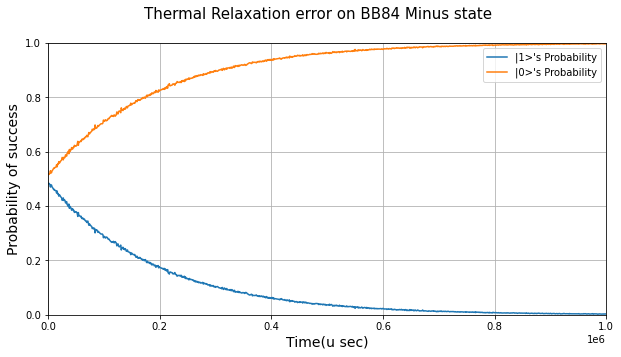

<Figure size 576x360 with 0 Axes>

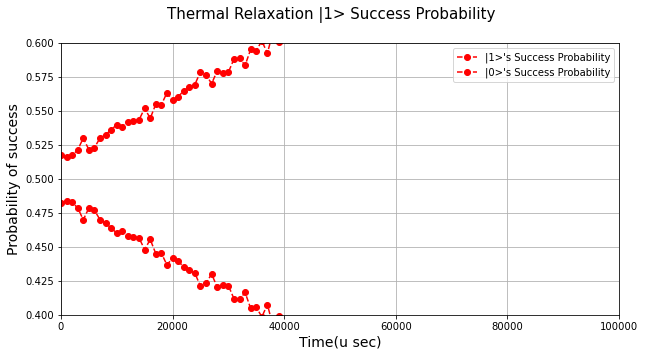

<Figure size 576x360 with 0 Axes>

In [64]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 Minus state',fontsize=15)
# naming the x axis
plt.xlabel('Time(u sec)',fontsize=14)
# naming the y axis
plt.ylabel('Probability of success',fontsize=14)
plt.grid()
# giving a title to my graph
# Set axis ranges; by default this will put major ticks every 25.
#ax.set_xlim(0, 300)
#ax.set_ylim(0, 1)
ax.set_xlim(0, 1000000)
ax.set_ylim(0,1)
fig = plt.figure(figsize=(8,5))
# line 2 points
x1=delay
x2=delay
#plotting the line 2 points
ax.plot(x1, yy1, label = "|1>'s Probability")
ax.plot(x2, yy2, label = "|0>'s Probability")

#ax.axes.xaxis.set_ticks([])
# show a legend on the plot
ax.legend()
########################################################################


%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation |1> Success Probability',fontsize=15)
ax.set_xlim(0, 100000)
ax.set_ylim(0.4,0.6)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec)',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,yy1,'ro--',label = "|1>'s Success Probability")
ax.plot(delay,yy2,'ro--',label = "|0>'s Success Probability")

ax.legend()